In [1]:
import sys; sys.path.append('..') # add project root to the python path

In [6]:
import gym
import torch
import matplotlib.pyplot as plt

from src.part3.MLP import MultiLayerPerceptron as MLP
from src.part4.PolicyGradient import REINFORCE
from src.common.train_utils import EMAMeter, to_tensor

In [3]:
env = gym.make('CartPole-v1')
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.n

C:\Users\joon0\Anaconda3\envs\gpu_torch130\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## REINFORCE 알고리즘으로, 'CartPole-V1'을 정복하기.

이번 실습에서는 `REINFORCE` 알고리즘으로 `CartPole-V1` MDP를 정복해볼까요?
`REINFORCE`의 의사코드는 다음과 같습니다.

<img src="./images/REINFORCE.png" width="60%" height="40%" title="REINFORCE" alt="REINFORCE"></img>

`REINFORCE` 알고리즘을 파이썬으로는 어떻게 구현할까요?
```python
import torch.nn as nn
from torch.distributions.categorical import Categorical

class REINFORCE(nn.Module):

    def __init__(self,
                 policy: nn.Module,
                 gamma: float = 1.0,
                 lr: float = 0.0002):
        super(REINFORCE, self).__init__()
        self.policy = policy  # make sure that 'policy' returns logits!
        self.gamma = gamma
        self.opt = torch.optim.Adam(params=self.policy.parameters(),
                                    lr=lr)

        self._eps = 1e-25

    def get_action(self, state):
        with torch.no_grad():
            logits = self.policy(state)
            dist = Categorical(logits=logits)
            a = dist.sample()  # sample action from softmax policy
        return a
```

### Logit? Catergorical?

Catergorical distribution (다항분포) 는 이항분포의 확장판입니다. <br>

>이항분포는 사건의 종류가 2개일 상황을 (예를 들어 한번 동전을 던져서 앞/뒤가 나올 확률) 모델링 할 때 자주 쓰이게 됩니다.
이항 분포의 매개변수는 $p$ 로 하나의 사건이 나올 확률을 표현합니다. 이때 $0 \leq p \leq 1$ 를 따르게 됩니다.

그렇다면 사건의 종류가 2개보다 많은 경우는 어떻게 할 수 있을까요? 그런 경우에 다항 분포를 사용해볼 수 있습니다.

> 사건의 종류가 $n$ 개 일때, 다항분포의 매개변수들 $(p_1, ..., p_n)$ 이 되며, $p_i$ 는 각 사건이 일어날 확률을 표현합니다.
> 따라서 $p_i$ 는 모두 0보다 크거나 같고, $\sum_{i=1}^{n} p_i =1$ 을 만족시켜야 합니다.

자 그러면, 이제 신경망 `self.policy(state)` 출력이 위의 조건을 만족시키게 만들 수 있을까요? 다양한 방법이 존재하지만, 가장 일반적인 선택은
softmax라는 연산자를 활용하는 것입니다.

$$\sigma(z)_i = \frac{e^{z_i}}{\sum_{j=1}^{n}e^{z_j}} \forall i=1,...,n$$

임의의 값들의 집합 $\{{z_i}\}_{i=1}^{n}$ 에 위에서 정의한 softmax 연산자를 가해주면, 모든 값들은 0 이상의 값으로 바뀌고 값들의 합은 1.0 이 되게 됩니다.
이때, $z_i$ 를 일반적으로 logit 이라고 부릅니다.

### Softmax를 직접 구현해봅시다.

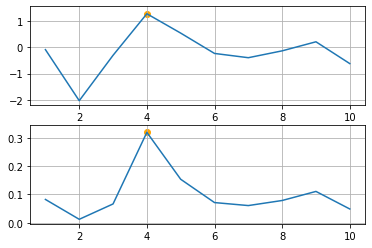

In [53]:
n_vars = 10
logits = torch.randn(n_vars)
max_idx = logits.argmax().item()

# softmax computation
probs = torch.exp(logits) / torch.exp(logits).sum()
prob_max_idx = probs.argmax().item()

fig,ax = plt.subplots(2,1)
ax[0].grid()
ax[0].plot(range(1,n_vars+1), logits)
ax[0].scatter(max_idx+1, logits[max_idx], c='orange')

ax[1].grid()
ax[1].plot(range(1,n_vars+1), probs)
ax[1].scatter(prob_max_idx+1, probs[prob_max_idx], c='orange')

### Softmax, one more thing!

softmax는 사실 temperature $T$라는 하나의 파라미터를 가지고 있습니다. (문헌에 따라서는 $\frac{1}{\beta}$ 라고 기술되는 경우도 있습니다.)

$$\sigma(z ; T)_i = \frac{e^{z_i/T}}{\sum_{j=1}^{n}e^{z_j/T}} \forall i=1,...,n$$

Temperature 파라미터 $T$는 softmax 결과값의 분포의 평평한 정도에 영향을 미칩니다.

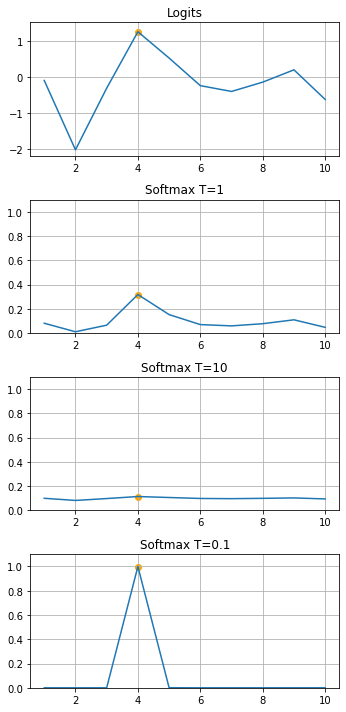

In [72]:
# softmax computation
t1 = 10
probs_t1 = torch.exp(logits/t1) / torch.exp(logits/t1).sum()

t2 = 0.1
probs_t2 = torch.exp(logits/t2) / torch.exp(logits/t2).sum()

fig,ax = plt.subplots(4,1, figsize=(5,10))
ax[0].grid()
ax[0].plot(range(1,n_vars+1), logits)
ax[0].scatter(max_idx+1, logits[max_idx], c='orange')
ax[0].set_title("Logits")

ax[1].grid()
ax[1].plot(range(1,n_vars+1), probs)
ax[1].scatter(prob_max_idx+1, probs[prob_max_idx], c='orange')
ax[1].set_ylim(0.0, 1.1)
ax[1].set_title("Softmax T=1")

ax[2].grid()
ax[2].plot(range(1,n_vars+1), probs_t1)
ax[2].scatter(prob_max_idx+1, probs_t1[prob_max_idx], c='orange')
ax[2].set_ylim(0.0, 1.1)
ax[2].set_title("Softmax T=10")

ax[3].grid()
ax[3].plot(range(1,n_vars+1), probs_t2)
ax[3].scatter(prob_max_idx+1, probs_t2[prob_max_idx], c='orange')
ax[3].set_ylim(0.0, 1.1)
_ = ax[3].set_title("Softmax T=0.1")
plt.tight_layout()

### Implemenation tip! 
> 일반적으로 NN계산 중에 `exp()` 연산은 선호되지 않습니다. 입력값이 작거나/클때 쉽게 값이 underflow/overflow 할 염려가 있기 때문인데요.
> 신경써서 구현하면 그런 문제들을 완화할 수 있지만, 매번 신경쓰기가 번거롭습니다. <br>

> softmax + Catergorical 사용같이 자주 사용되는 패턴은 pytorch 수준에서 최대한 numerical stability를 가지도록 만들어져 있습니다. 그 예시 중에 하나로 pytorch 의 `Catergorical`은 logit값으로 부터 생성하는것이 가능합니다. 따라서, 직접 softmax를 계산한 후 `Catergorical` 매개변수로 사용하는것 보다는 `Catergorical`분포의 매개변수로 `logit`을 넘겨주는 것이 조금 더 안전합니다.



### 이제 `update` 를 살펴볼까요?

```python
    @staticmethod
    def _pre_process_inputs(episode):
        states, actions, rewards = episode

        # assume inputs as follows
        # s : torch.tensor [num.steps x state_dim]
        # a : torch.tensor [num.steps]
        # r : torch.tensor [num.steps]

        # reversing inputs
        states = states.flip(dims=[0])
        actions = actions.flip(dims=[0])
        rewards = rewards.flip(dims=[0])
        return states, actions, rewards

    def update(self, episode):
        # sample-by-sample update version of REINFORCE
        # sample-by-sample update version is highly inefficient in computation
        states, actions, rewards = self._pre_process_inputs(episode)

        g = 0
        for s, a, r in zip(states, actions, rewards):
            g = r + self.gamma * g
            dist = Categorical(logits=self.policy(s))
            prob = dist.probs[a]

            # Don't forget to put '-' in the front of pg_loss !!!!!!!!!!!!!!!!
            # the default behavior of pytorch's optimizer is to minimize the targets
            # add 'self_eps' to prevent numerical problems of logarithms
            pg_loss = - torch.log(prob + self._eps) * g

            self.opt.zero_grad()

            pg_loss.backward()
            self.opt.step()
```

In [ ]:
net = MLP(s_dim, a_dim, [128])
agent = REINFORCE(net)
ema = EMAMeter()

In [ ]:
n_eps = 10000
print_every = 500

for ep in range(n_eps):
    s = env.reset()
    cum_r = 0

    states = []
    actions = []
    rewards = []

    while True:
        s = to_tensor(s, size=(1, 4))
        a = agent.get_action(s)
        ns, r, done, info = env.step(a.item())

        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = ns
        cum_r += r
        if done:
            break

    ema.update(cum_r)
    if ep % print_every == 0:
        print("Episode {} || EMA: {} ".format(ep, ema.s))

    states = torch.cat(states, dim=0)  # torch.tensor [num. steps x state dim]
    actions = torch.stack(actions).squeeze()  # torch.tensor [num. steps]
    rewards = torch.tensor(rewards)  # torch.tensor [num. steps]

    episode = (states, actions, rewards)
    agent.update_episode(episode, use_norm=True)